In [1]:
%matplotlib inline

In [2]:
# add repo path
import sys
sys.path.append('/home/gautam_sisodia/gen-purpose-repo/')

In [3]:
import gym
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rl import frozenlake as fl

[2017-10-11 23:02:10,034] Making new env: FrozenLake-v0


In [5]:
plt.style.use('seaborn-darkgrid')

In [6]:
env = gym.make('FrozenLake-v0')
env.reset()
env.render()

[2017-10-11 23:02:10,115] Making new env: FrozenLake-v0



SFFF
FHFH
FFFH
HFFG


## General Stats
Gathering some general statistics about states from random actions

In [7]:
state_dict = False

In [8]:
state_dict, rand_game_df = fl.run_n_games(20000, fl.rand_strategy, state_dict)

100%|██████████| 20000/20000 [00:03<00:00, 5777.08it/s]


In [9]:
fl.print_game_stats(rand_game_df)

Total number of moves: 154194
Number of moves per game: 7.7097
Total number of games won: 302.0
Percentage of games won: 1.51


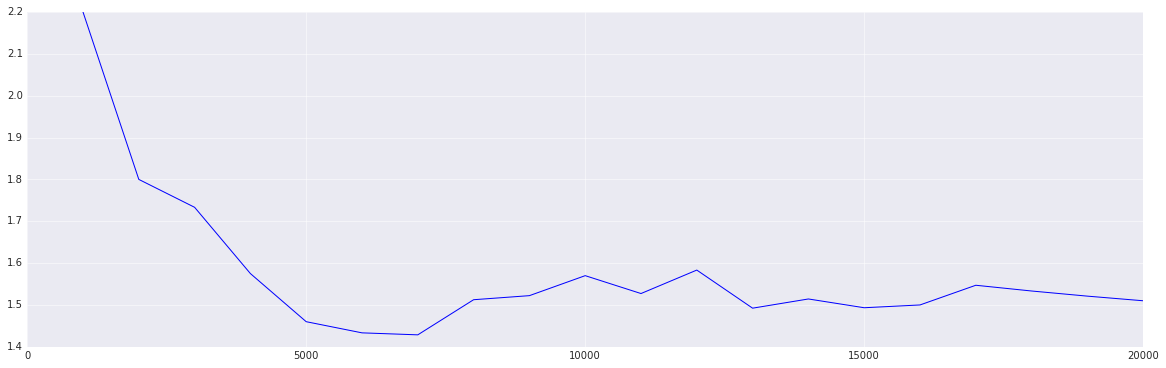

In [10]:
fl.plot_winning_percentage(rand_game_df)

## Q-Learning via table

In [11]:
# try zero initialization
# q_table = np.zeros((env.observation_space.n, env.action_space.n))
q_table = np.random.rand(env.observation_space.n, env.action_space.n) * 0.0001

In [12]:
# set gamma
gamma = 0.95

# set learning rate
learning_rate = 0.9

In [14]:
def q_table_pick_action(current_state, current_game):
    return np.argmax(q_table[current_state,:] + np.random.randn(1, env.action_space.n) * (1.0 / (current_game + 1)))

def q_table_update_strategy(current_state, action, next_state, reward, game_end):
    q_table[current_state, action] = q_table[current_state, action] -\
      learning_rate * (q_table[current_state, action] - reward - gamma * np.max(q_table[next_state, :]))

q_table_strategy = fl.Strategy(q_table_pick_action, q_table_update_strategy)

In [15]:
state_dict = False

In [23]:
state_dict, q_table_game_df = fl.run_n_games(1000, q_table_strategy, state_dict)

100%|██████████| 1000/1000 [00:01<00:00, 561.97it/s]


In [24]:
fl.print_game_stats(q_table_game_df)

Total number of moves: 149258
Number of moves per game: 37.3145
Total number of games won: 2237.0
Percentage of games won: 55.925


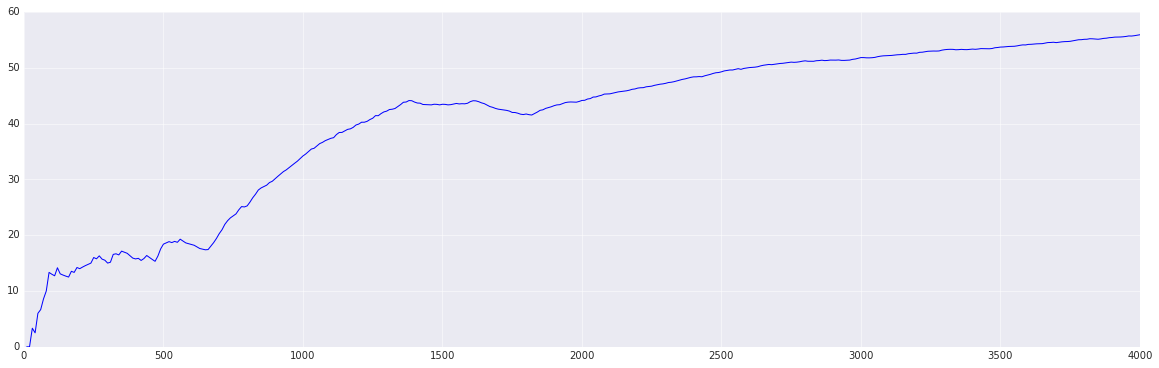

In [27]:
fl.plot_winning_percentage(q_table_game_df, gap = 10)

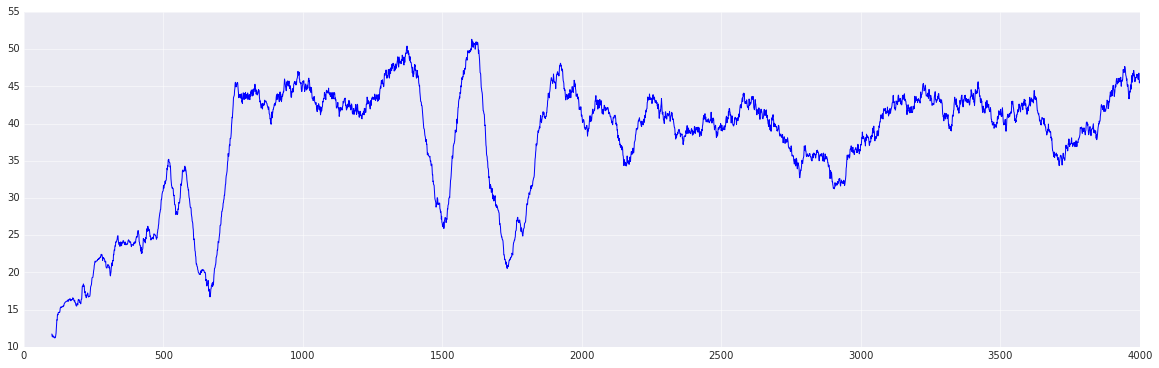

In [31]:
fl.plot_game_length(q_table_game_df, window = 100)

## Q learning with neural networks

In [147]:
tf.reset_default_graph()

In [148]:
gamma = 0.99
learning_rate = 0.1

In [165]:
# make the network
def make_network():
    input_layer = tf.placeholder(shape = [1, 16], dtype = tf.float32, name = "input_layer")
    W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
    Q = tf.matmul(input_layer, W)
    prediction = tf.argmax(Q, 1)

    label = tf.placeholder(shape=[1, 4], dtype = tf.float32)
    loss = tf.reduce_sum(tf.square(Q - label))
    trainer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    update = trainer.minimize(loss)

In [166]:
make_network()

In [150]:
# initialze tensorflow session and global variables
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [151]:
def get_state_vector(state):
    return np.identity(16)[state: state + 1]

def q_nn_pick_action(current_state, current_game):
    
    rand_chance = 1.0 / ((1.0 * current_game /50) + 10)
    
    if np.random.rand(1) < rand_chance:
        return env.action_space.sample()
    else:
        return sess.run(prediction, feed_dict = {input_layer: get_state_vector(current_state)})[0]

def q_nn_update_strategy(current_state, action, next_state, reward, game_end):
    current_q = sess.run(Q, feed_dict = {input_layer: get_state_vector(current_state)})
    next_q = sess.run(Q, feed_dict = {input_layer: get_state_vector(next_state)})
    max_next_q = np.max(next_q)
    current_q[0, action] = reward + gamma * max_next_q
    sess.run(update, feed_dict = {input_layer: get_state_vector(current_state), label: current_q})

q_nn_strategy = fl.Strategy(q_nn_pick_action, q_nn_update_strategy)

In [152]:
state_dict = False

In [161]:
state_dict, q_nn_game_df = fl.run_n_games(2000, q_nn_strategy, state_dict)

100%|██████████| 2000/2000 [01:15<00:00, 26.64it/s]


In [162]:
fl.print_game_stats(q_nn_game_df)

Total number of moves: 199679
Number of moves per game: 33.279833333333336
Total number of games won: 3184.0
Percentage of games won: 53.06666666666667


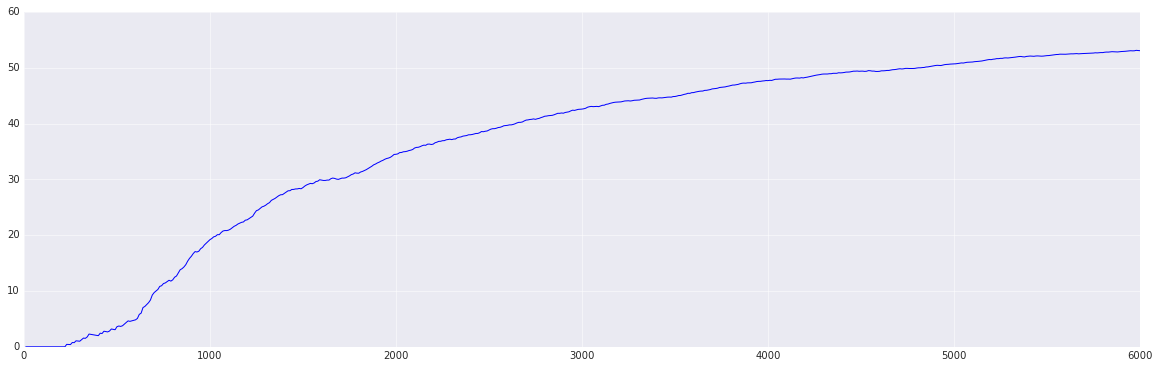

In [163]:
fl.plot_winning_percentage(q_nn_game_df, gap = 10)

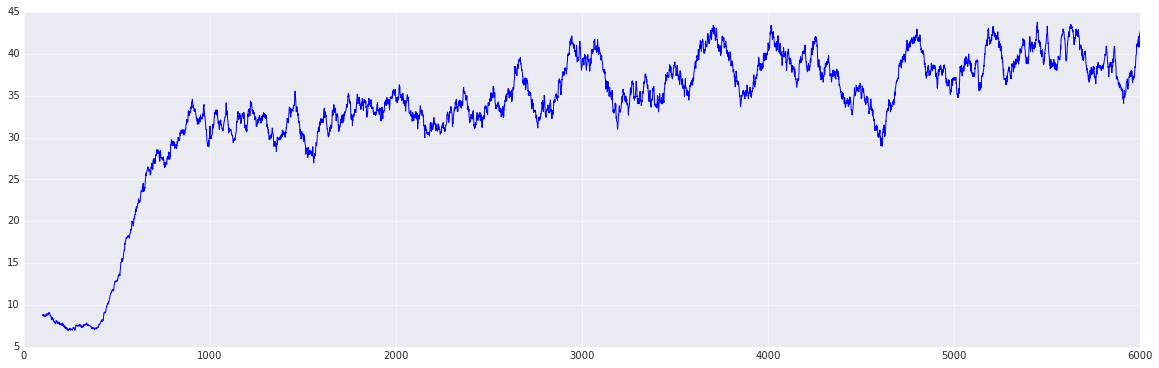

In [164]:
fl.plot_game_length(q_nn_game_df, window = 100)